In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')
path_basic = 'drive/My Drive/face-swap'
os.chdir(path_basic)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL.Image as Image
from tqdm import tqdm_notebook
import glob
import random
import time


import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
import torchvision
from torchvision import transforms as trans

from face_modules.model import Backbone, Arcface, MobileFaceNet, Am_softmax, l2_norm
from face_modules.mtcnn import MTCNN
from fid import fid_score

In [3]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        m.bias.data.zero_()
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)

    if isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight.data)

In [4]:
class Convolution(nn.Module):
  def __init__(self, input_nc, output_nc, 
               kernel_size=4, 
               padding=1, 
               stride=2, 
               bias=False):
    
    super(Convolution, self).__init__()
    model = [
             nn.Conv2d(input_nc, output_nc, 
                       kernel_size=kernel_size,
                       stride=stride,
                       padding=padding,
                       bias=bias),
             nn.BatchNorm2d(output_nc),
             nn.LeakyReLU(0.1, True)
    ]
    self.model = nn.Sequential(*model)


  def forward(self, x):
    return self.model(x)


class Deconvolution(nn.Module):
  def __init__(self, input_nc, output_nc, 
               kernel_size=4, 
               padding=1, 
               stride=2, 
               bias=False):
    
    super(Deconvolution, self).__init__()
    model = [
             nn.ConvTranspose2d(input_nc, output_nc, 
                                kernel_size=kernel_size,
                                stride=stride,
                                padding=padding,
                                bias=bias),
             nn.BatchNorm2d(output_nc),
             nn.LeakyReLU(0.1, True)
    ]
    self.model = nn.Sequential(*model)


  def forward(self, x, skip):
    return torch.cat([self.model(x), skip], dim=1)      

In [5]:
class AttributeNetwork(nn.Module):
  def __init__(self, input_nc, num_filters=16):
    super(AttributeNetwork, self).__init__()

    self.d1 = Convolution(input_nc, num_filters)
    self.d2 = Convolution(num_filters, num_filters * 2)
    self.d3 = Convolution(num_filters * 2, num_filters * 4)
    self.d4 = Convolution(num_filters * 4, num_filters * 8)
    self.z1_att = Convolution(num_filters * 8, num_filters * 8)

    self.z2_att = Deconvolution(num_filters * 8, num_filters * 8)
    self.z3_att = Deconvolution(num_filters * 8 * 2, num_filters * 4)
    self.z4_att = Deconvolution(num_filters * 4 * 2, num_filters * 2)
    self.z5_att = Deconvolution(num_filters * 2 * 2, num_filters)
    self.apply(weights_init)
  
  def forward(self, x):
    # print(f"Input: {x.shape}")
    d1 = self.d1(x)  # n_f*1, H/2, W/2
    # print(f"d1: {d1.shape}")
    d2 = self.d2(d1)  # n_f*2, H/4, W/4
    # print(f"d2: {d2.shape}")
    d3 = self.d3(d2)  # n_f*4, H/8, W/8
    # print(f"d3: {d3.shape}")
    d4 = self.d4(d3)  # n_f*8, H/16, W/16
    # print(f"d4: {d4.shape}")
    z1_att = self.z1_att(d4)  # n_f*8, H/32, W/32
    # print(f"z1: {z1_att.shape}")
    z2_att = self.z2_att(z1_att, d4)  # n_f * 8, H/16, W/16
    # print(f"z2: {z2_att.shape}")
    z3_att = self.z3_att(z2_att, d3)  # n_f * 4, H/8, W/8
    # print(f"z3: {z3_att.shape}")
    z4_att = self.z4_att(z3_att, d2)  # n_f * 2, H/4, W/4
    # print(f"z4: {z4_att.shape}")
    z5_att = self.z5_att(z4_att, d1)  # n_f * 1, H/2, W/2
    # print(f"z5: {z5_att.shape}")
    z6_att = F.interpolate(z5_att, scale_factor=2, mode='bilinear', 
                           align_corners=True)  # n_f * 1, H, W
    # print(f"z6: {z6_att.shape}")
    return z1_att, z2_att, z3_att, z4_att, z5_att, z6_att

In [6]:
test_input = torch.rand(1, 3, 64, 64)
model = AttributeNetwork(3, 16)
res = model(test_input)

In [7]:
class AADModule(nn.Module):
  def __init__(self, h_nc, att_nc, id_nc=512):
    super(AADModule, self).__init__()
    self.h_nc = h_nc
    self.att_nc = att_nc
    self.id_nc = id_nc

    self.in_norm = nn.InstanceNorm2d(h_nc, affine=False)
    self.conv1 = nn.Conv2d(att_nc, h_nc, kernel_size=1, bias=True)
    self.conv2 = nn.Conv2d(att_nc, h_nc, kernel_size=1, bias=True)
    self.fc1 = nn.Linear(id_nc, h_nc)
    self.fc2 = nn.Linear(id_nc, h_nc)
    
    self.conv_h = nn.Conv2d(h_nc, 1, kernel_size=1, bias=True)

  def forward(self, z_att, z_id, h):
    h_k = self.in_norm(h)
    gamma_att = self.conv1(z_att)
    beta_att = self.conv2(z_att)
    
    gamma_id = self.fc1(z_id)
    beta_id = self.fc2(z_id)

    A_k = gamma_att * h_k + beta_att

    gamma_id = gamma_id.reshape(h_k.shape[0], self.h_nc, 1, 1).expand_as(h_k)
    beta_id = beta_id.reshape(h_k.shape[0], self.h_nc, 1, 1).expand_as(h_k)
    I_k = gamma_id * h_k + beta_id

    M_k = torch.sigmoid(self.conv_h(h_k))
    O = (torch.ones_like(M_k).to(M_k.device) - M_k) * A_k + M_k * I_k

    return O

In [ ]:
z_id = torch.rand(1,1,1,512)
z_att = torch.rand(1,64, 16,16)
h = torch.rand(1,32, 16,16)
model = AADModule(32, 64, 512)
res = model(z_att, z_id, h)

In [19]:
class AADResBlk(nn.Module):
  def __init__(self, input_nc, output_nc, att_nc, id_nc=512):
    super(AADResBlk, self).__init__()
    self.input_nc = input_nc
    self.output_nc = output_nc

    self.AAD1 = AADModule(input_nc, att_nc, id_nc=id_nc)
    self.relu1 = nn.ReLU(True)
    self.conv1 = nn.Conv2d(input_nc, input_nc, kernel_size=3, padding=1, bias=False)

    self.AAD2 = AADModule(input_nc, att_nc, id_nc=id_nc)
    self.relu2 = nn.ReLU(True)
    self.conv2 = nn.Conv2d(input_nc, output_nc, kernel_size=3, padding=1, bias=False)

    if self.input_nc != self.output_nc:
      self.AAD3 = AADModule(input_nc, att_nc, id_nc)
      self.relu3 = nn.ReLU(True)
      self.conv3 = nn.Conv2d(input_nc, output_nc, kernel_size=3, padding=1, bias=False)


  def forward(self, z_att, z_id, h):
    x = self.AAD1(z_att, z_id, h)
    x = self.relu1(x)
    x = self.conv1(x)

    x = self.AAD2(z_att, z_id, x)
    x = self.relu2(x)
    x = self.conv2(x)

    if self.input_nc != self.output_nc:
      h = self.AAD3(z_att, z_id, h)
      h = self.relu3(h)
      h = self.conv3(h)

    output = h + x
    return output

In [ ]:
z_id = torch.rand(1,1,1,512)
z_att = torch.rand(1,64, 16,16)
h = torch.rand(1,64, 16,16)
model = AADResBlk(64, 32, 64, 512)
res = model(z_att, z_id, h)

In [ ]:
res.shape

torch.Size([1, 32, 16, 16])

In [9]:
class AADGenerator(nn.Module):
  def __init__(self, output_nc, id_nc=512, nf=128):
    super(AADGenerator, self).__init__()

    self.up1 = nn.ConvTranspose2d(id_nc, 512, kernel_size=2, stride=1)
    
    self.AAD1 = AADResBlk(input_nc=512, output_nc=512, att_nc=nf, id_nc=id_nc)
    self.AAD2 = AADResBlk(input_nc=512, output_nc=512, att_nc=nf * 2, id_nc=id_nc)
    self.AAD3 = AADResBlk(input_nc=512, output_nc=256, att_nc=nf, id_nc=id_nc)
    self.AAD4 = AADResBlk(input_nc=256, output_nc=128, att_nc=nf // 2, id_nc=id_nc)
    self.AAD5 = AADResBlk(input_nc=128, output_nc=64, att_nc=nf // 4, id_nc=id_nc)
    self.AAD6 = AADResBlk(input_nc=64, output_nc=output_nc, att_nc=nf // 4, id_nc=id_nc)
    
    self.apply(weights_init)

  def forward(self, z_atts, z_id):
    x = self.up1(z_id.reshape(z_id.shape[0],-1,1,1))
    # print("First: ", x.shape)
    u1 = F.interpolate(self.AAD1(z_atts[0], z_id, x), 
                       scale_factor=2, 
                       mode='bilinear', 
                       align_corners=True)
    # print("u1: ", u1.shape)
    u2 = F.interpolate(self.AAD2(z_atts[1], z_id, u1), 
                       scale_factor=2, 
                       mode='bilinear', 
                       align_corners=True)
    # print("u2: ", u2.shape)
    u3 = F.interpolate(self.AAD3(z_atts[2], z_id, u2), 
                       scale_factor=2, 
                       mode='bilinear', 
                       align_corners=True)
    # print("u3: ", u3.shape)
    u4 = F.interpolate(self.AAD4(z_atts[3], z_id, u3), 
                       scale_factor=2, 
                       mode='bilinear', 
                       align_corners=True)
    # print("u4: ", u4.shape)
    u5 = F.interpolate(self.AAD5(z_atts[4], z_id, u4), 
                       scale_factor=2, 
                       mode='bilinear', 
                       align_corners=True)
    # print("u5: ", u5.shape)
    output = self.AAD6(z_atts[5], z_id, u5)
    # print("output: ", output.shape)
    return torch.tanh(output)

In [ ]:
n_f_atts = 16
n_f_idt = n_f_atts * 8
atts_net = AttributeNetwork(3, n_f_atts)
gen = AADGenerator(3, 512, n_f_idt)

In [ ]:
input_atts = torch.rand(1, 3, 64, 64)
atts = atts_net(input_atts)

In [ ]:
input_id = torch.rand(1,1,1,512)
res = gen(atts, input_id)

First:  torch.Size([1, 512, 2, 2])
u1:  torch.Size([1, 512, 4, 4])
u2:  torch.Size([1, 256, 8, 8])
u3:  torch.Size([1, 128, 16, 16])
u4:  torch.Size([1, 64, 32, 32])
u5:  torch.Size([1, 32, 64, 64])
output:  torch.Size([1, 3, 64, 64])


In [ ]:
res.shape

torch.Size([1, 3, 64, 64])

In [10]:
class AEI_Net(nn.Module):
    def __init__(self, output_nc, id_nc=512, nf_gen=128, nf_att=16):
        super(AEI_Net, self).__init__()
        self.encoder = AttributeNetwork(3, num_filters=nf_att)
        self.generator = AADGenerator(output_nc, 
                                      id_nc=id_nc, 
                                      nf=nf_gen)

    def forward(self, Xt, z_id):
        attrs = self.encoder(Xt)
        Y = self.generator(attrs, z_id)
        return Y, attrs

    def get_attr(self, X):
        return self.encoder(X)

### Discriminator

In [11]:
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, 
                 use_sigmoid=False, getIntermFeat=False):
        super(NLayerDiscriminator, self).__init__()
        self.n_layers = n_layers

        kw = 4
        padw = int(np.ceil((kw-1.0)/2))
        sequence = [[nn.utils.spectral_norm(nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw)), 
                     nn.LeakyReLU(0.2, True)]]

        nf = ndf
        for n in range(1, n_layers):
            nf_prev = nf
            nf = min(nf * 2, 512)
            sequence += [[
                nn.utils.spectral_norm(nn.Conv2d(nf_prev, nf, kernel_size=kw, stride=2, padding=padw)),
                norm_layer(nf), nn.LeakyReLU(0.2, True)
            ]]

        nf_prev = nf
        nf = min(nf * 2, 512)
        sequence += [[
            nn.utils.spectral_norm(nn.Conv2d(nf_prev, nf, kernel_size=kw, stride=1, padding=padw)),
            norm_layer(nf),
            nn.LeakyReLU(0.2, True)
        ]]

        sequence += [[nn.utils.spectral_norm(nn.Conv2d(nf, 1, kernel_size=kw, stride=1, padding=padw))]]

        if use_sigmoid:
            sequence += [[nn.Sigmoid()]]


        sequence_stream = []
        for n in range(len(sequence)):
            sequence_stream += sequence[n]
        self.model = nn.Sequential(*sequence_stream)

    def forward(self, input):
        return self.model(input)


class MultiscaleDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d,
                 use_sigmoid=False, num_D=3, getIntermFeat=False):
        super(MultiscaleDiscriminator, self).__init__()
        self.num_D = num_D
        self.n_layers = n_layers
        self.getIntermFeat = getIntermFeat

        for i in range(num_D):
            netD = NLayerDiscriminator(input_nc, ndf, n_layers, norm_layer, use_sigmoid, getIntermFeat)
            setattr(self, 'layer' + str(i), netD.model)

        self.downsample = nn.AvgPool2d(3, stride=2, padding=[1, 1], count_include_pad=False)

        self.apply(weights_init)

    def singleD_forward(self, model, input):
        return [model(input)]

    def forward(self, input):
        num_D = self.num_D
        result = []
        input_downsampled = input
        for i in range(num_D):
            model = getattr(self, 'layer' + str(num_D - 1 - i))
            result.append(self.singleD_forward(model, input_downsampled))
            if i != (num_D - 1):
                input_downsampled = self.downsample(input_downsampled)
        return result

In [ ]:
D = MultiscaleDiscriminator(3, ndf=64, n_layers=3, norm_layer=nn.InstanceNorm2d, num_D=2)
test_input = torch.rand(1,3,64,64)
res = D(test_input)

In [ ]:
res[1][0].shape

torch.Size([1, 1, 7, 7])

### Num params

In [ ]:
D = MultiscaleDiscriminator(3, ndf=32, n_layers=3, 
                            norm_layer=nn.InstanceNorm2d, num_D=3)
model = AEI_Net(3, nf_att=64, nf_gen=512)

In [ ]:
# summary of the models
def num_params(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  return params

D_num = round(num_params(D) * 2 / 1e6, 3) * 2
G_num = round(num_params(model) * 2 / 1e6, 3) * 2
ovr_num = D_num + G_num

print('---- Summary models ----')
print("Number of parameters (in millions):")
print("{:10}{:10}{:20}".format("D", 'G', "Overall"))
print("{:10}{:10}{:20}".format(str(D_num), str(G_num), str(ovr_num)))

---- Summary models ----
Number of parameters (in millions):
D         G         Overall             
8.33      174.816   183.14600000000002  


### Dataset

In [12]:
class FaceDataset(Dataset):
  def __init__(self, pathes_ffhq, root_vgg_face, same_prob=0.8, is_train=True):
    self.same_prob = same_prob
    self.is_train = is_train
    self.pathes_ffhq = pathes_ffhq
    if root_vgg_face is None:
      self.vgg_prob = 1.
    else:
      self.vgg_prob = 0.8
      self.folders_vgg = glob.glob(os.path.join(root_vgg_face, '*'))
      self.pathes_vgg = {}
      for folder in self.folders_vgg:
        self.pathes_vgg[folder] = glob.glob(os.path.join(folder, '*.png'))
    
    if is_train:
      self.transforms = trans.Compose([
                                      trans.ColorJitter(.2,.2,.2,.01),
                                      trans.ToTensor(),
                                      trans.Normalize((.5,.5,.5), (.5,.5,.5))
      ])
      
    else:
      self.transforms = trans.Compose([
                                      trans.ToTensor(),
                                      trans.Normalize((.5,.5,.5), (.5,.5,.5))
      ])
      random.seed(17)
      # self.same_prob=0.  # only images of different people are extracted


  def __getitem__(self, index):
    if random.random() > self.same_prob:
      same_person = 0
      if random.random() > self.vgg_prob:
        # vgg face - taking random pictures of two individuals
        folder_1_idx = random.randint(0, len(self.folders_vgg) - 1)
        folder_2_range = list(range(len(self.folders_vgg)))
        folder_2_range.remove(folder_1_idx)
        folder_2_idx = folder_2_range[random.randint(0, len(folder_2_range)- 1)]

        folder_1 = self.folders_vgg[folder_1_idx]
        folder_2 = self.folders_vgg[folder_2_idx]

        image_path_1 = self.pathes_vgg[folder_1][random.randint(0, len(self.pathes_vgg[folder_1])-1)]
        image_path_2 = self.pathes_vgg[folder_2][random.randint(0, len(self.pathes_vgg[folder_2])-1)]

        Xs = self.transforms(Image.open(image_path_1))
        Xt = self.transforms(Image.open(image_path_2))
      
      else:
        # ffhq dataset - take random two different photos
        image_path = self.pathes_ffhq[index]
        Xs = self.transforms(Image.open(image_path))
        image_path = self.pathes_ffhq[random.randint(0, len(self.pathes_ffhq)-1)]
        Xt = self.transforms(Image.open(image_path))
    else:
      same_person = 1
      if not self.is_train:
        image_path = self.pathes_ffhq[index]
        Xs = Image.open(image_path)
        Xt = Xs.copy()
        Xs = self.transforms(Xs)
        Xt = self.transforms(Xt)
        
      else:
        # take two photos of same individual from vggface
        folder_1 = self.folders_vgg[random.randint(0, len(self.folders_vgg) - 1)]
        image_path_1 = self.pathes_vgg[folder_1][random.randint(0, len(self.pathes_vgg[folder_1])-1)]
        image_path_2 = self.pathes_vgg[folder_1][random.randint(0, len(self.pathes_vgg[folder_1])-1)]
        Xs = self.transforms(Image.open(image_path_1))
        Xt = self.transforms(Image.open(image_path_2))
      
    return {'Xs':Xs,
            'Xt':Xt,
            'same_person':same_person}


  def __len__(self):
    return len(self.pathes_ffhq)

In [25]:
d = FaceDataset(train_pathes, None, same_prob=0.8, is_train=False)
res = d[3]
res['same_person']

1

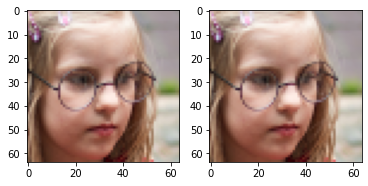

In [26]:
img_1 = ((res['Xs']+1)*127.5).numpy().transpose([1,2,0]).astype(np.uint8)
img_2 = ((res['Xt']+1)*127.5).numpy().transpose([1,2,0]).astype(np.uint8)
plt.subplots()
plt.subplot(1,2,1)
plt.imshow(img_1)
plt.subplot(1,2,2)
plt.imshow(img_2)

### Training script

In [ ]:
# _=[os.remove(f) for f in glob.glob(os.path.join(SUMMARY_DIR, '*.*'))]
# _=[os.remove(f) for f in glob.glob(os.path.join(IMAGES_DIR, '*.*'))]

In [13]:
ROOT_DIR='data_mtcnn'
ROOT_VGG='vgg_face_mtcnn'
CHECKPOINTS_DIR = 'info/checkpoints/SN_D_LS_vggface_heavier/2/'
SUMMARY_DIR = 'info/summary/SN_D_LS_vggface_heavier/01/'
IMAGES_DIR = 'info/images/SN_D_LS_vggface_heavier/01/'
FID_DIR = 'info/fid/SN_D_LS_vggface_heavier/01/'
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
os.makedirs(SUMMARY_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(FID_DIR, exist_ok=True)

DEVICE=torch.device('cuda')
ID_NC=512   # dim of identity vector
NF_ATT=64   # num filters at the start of att network. should be consistent with NF_GEN
NF_GEN=NF_ATT*8  # num filters at the start of generator(for attributes)
NDF = 32    # num filters for discriminator to begin with
N_DIS_LAYERS = 3
NUM_D = 3   # number of discriminator networks
LR_G = 4e-4
LR_D = 4e-4
BATCH_SIZE=64
NUM_EPOCHS=100

COEF_REC = 50
COEF_ATT = 100
COEF_ID  = 0.1
COEF_ADV = 1
REAL_LABEL=0.9

LOG_SNAP=5
IMAGE_SNAP=20
VAL_SNAP=100
LOAD=False

ID_LOAD=1
ID_SAVE=1

In [14]:
import pickle
if os.path.exists('train_pathes.pickle'):
  with open('train_pathes.pickle', 'rb') as f:
    train_pathes = pickle.load(f)
  with open('val_pathes.pickle', 'rb') as f:
    test_pathes = pickle.load(f)

else:
  
  from sklearn.model_selection import train_test_split
  all_pathes = glob.glob(os.path.join(ROOT_DIR, '*.png'))
  train_pathes, test_pathes = train_test_split(all_pathes, random_state=17, 
                                              test_size=.02, shuffle=True)
len(train_pathes), len(test_pathes)

(68418, 1397)

In [15]:
def get_grid_image(X):
    X = X[:8]
    X = torchvision.utils.make_grid(X.detach().cpu(), nrow=X.shape[0]) * 0.5 + 0.5
    return X


def make_image(Xs, Xt, Y):
    Xs = get_grid_image(Xs)
    Xt = get_grid_image(Xt)
    Y = get_grid_image(Y)
    return torch.cat((Xs, Xt, Y), dim=1).numpy()

In [16]:
d = FaceDataset(train_pathes, root_vgg_face=ROOT_VGG,same_prob=0.8)

In [17]:
[f for f in d.folders_vgg if len(d.pathes_vgg[f]) == 0]

[]

In [20]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

class Trainer():
  def __init__(self):
    # DEFINE NETWORKS
    self.G = AEI_Net(3, id_nc=ID_NC, nf_gen=NF_GEN, nf_att=NF_ATT)
    self.D = MultiscaleDiscriminator(3, ndf=NDF, n_layers=N_DIS_LAYERS, 
                                     norm_layer=nn.InstanceNorm2d,
                                     num_D=NUM_D)

    self.arcface = Backbone(50, 0.6, 'ir_se')
    self.arcface.eval()
    self.arcface.load_state_dict(torch.load('./face_modules/models/model_ir_se50.pth', 
                                            map_location=DEVICE), strict=False)
    self.G.train()
    self.D.train()
    self.G.to(DEVICE)
    self.D.to(DEVICE)
    self.arcface.to(DEVICE)

    # OPTIMIZERS
    self.optimizer_G = torch.optim.Adam(self.G.parameters(), lr=LR_G, betas=(0., .999))
    self.optimizer_D = torch.optim.Adam(self.D.parameters(), lr=LR_D, betas=(0., .999))

    # LOSSES
    self.criterion_MSE = nn.MSELoss().to(DEVICE)
    l1_loss = nn.L1Loss()

    # DATA
    self.train_dataloader = DataLoader(FaceDataset(train_pathes, 
                                                   root_vgg_face=ROOT_VGG,
                                                   same_prob=0.8), 
                                 batch_size=BATCH_SIZE, 
                                 shuffle=True,
                                 num_workers=os.cpu_count(),
                                 drop_last=True,
                                 pin_memory=True)
    

    self.val_dataloader = DataLoader(FaceDataset(test_pathes,
                                                 root_vgg_face=None, 
                                                 same_prob=0.8,
                                                 is_train=False),
                                 batch_size=BATCH_SIZE,
                                 shuffle=False,
                                 num_workers=os.cpu_count(),
                                 drop_last=True,
                                 pin_memory=True)
    
    # VARIABLES
    self.Tensor = torch.cuda.FloatTensor
    self.input_Xs = self.Tensor(BATCH_SIZE, 3, 64, 64)
    self.input_Xt = self.Tensor(BATCH_SIZE, 3, 64, 64)
    self.input_same_person = self.Tensor(BATCH_SIZE,)

    self.target_real = Variable(self.Tensor(BATCH_SIZE).fill_(REAL_LABEL), requires_grad=False)
    self.target_fake = Variable(self.Tensor(BATCH_SIZE).fill_(0.0), requires_grad=False)

    # WRITER
    self.writer = SummaryWriter(SUMMARY_DIR)

  
  def train(self):
    epoch = 0
    step = 0

    if LOAD:
      # load the last checkpoint
      epoch, step = self.load_model()

    ep_copy = epoch

    try:
      for ep in tqdm_notebook(range(epoch, NUM_EPOCHS), total=NUM_EPOCHS-epoch):
        ep_copy = ep
        for batch in tqdm_notebook(self.train_dataloader, total=len(self.train_dataloader)):
          start_time = time.time()
          Xs = Variable(self.input_Xs.copy_(batch['Xs']))
          Xt = Variable(self.input_Xt.copy_(batch['Xt']))
          same_person = Variable(self.input_same_person.copy_(batch['same_person']))

          # get identity embedding
          with torch.no_grad():
            Xs_embed, _ = self.arcface(F.interpolate(Xs, size=[112,112], 
                                                  mode='bilinear', align_corners=True))
          
          # train G
          self.optimizer_G.zero_grad()
          Y, Xt_attrs = self.G(Xt, Xs_embed)
          Di = self.D(Y)
          
          # adversarial loss
          L_adv = 0
          for d in Di:
            L_adv += self.criterion_MSE(d[0], (torch.ones_like(d[0]) * REAL_LABEL).to(DEVICE))
          
          # identity loss
          Y_embed, _ = self.arcface(F.interpolate(Y, size=[112,112], 
                                                mode='bilinear', align_corners=True))
          L_idt = (1 - torch.cosine_similarity(Xs_embed, Y_embed, dim=1)).mean()

          # attribute loss
          Y_attrs = self.G.get_attr(Y)
          L_att = 0
          for i in range(len(Y_attrs)):
            L_att += torch.mean(torch.pow(Xt_attrs[i] - Y_attrs[i], 2).reshape(BATCH_SIZE, -1), dim=1).mean()
          L_att /= 2

          # reconstruction loss
          L_rec = torch.sum(.5 * torch.mean(torch.pow(Y - Xt, 2).reshape(BATCH_SIZE, -1), dim=1) * same_person) / (same_person.sum() + 1e-6)

          loss_G = COEF_ADV * L_adv + COEF_ATT * L_att + COEF_REC * L_rec + COEF_ID * L_idt
          loss_G.backward()
          self.optimizer_G.step()

          # train D
          self.optimizer_D.zero_grad()
          
          fake_D = self.D(Y.detach())
          L_fake = 0
          for d in fake_D:
            L_fake += self.criterion_MSE(d[0], torch.zeros_like(d[0]).to(DEVICE))
          
          true_D = self.D(Xs)
          L_true = 0
          for d in true_D:
            L_true += self.criterion_MSE(d[0], (torch.ones_like(d[0]) * REAL_LABEL).to(DEVICE))
          # consider using target image as well

          loss_D = .5 * (L_true + L_fake)
          loss_D.backward()
          self.optimizer_D.step()

          # SUMMARY
          step += 1
          if step % LOG_SNAP == 0:
            
            self.writer.add_scalar('Loss/L_adv', L_adv.item(), global_step=step)
            self.writer.add_scalar('Loss/L_idt', L_idt.item(), global_step=step)
            self.writer.add_scalar('Loss/L_att', L_att.item(), global_step=step)
            self.writer.add_scalar('Loss/L_rec', L_rec.item(), global_step=step)
            self.writer.add_scalar('Loss/G', loss_G.item(), global_step=step)
            self.writer.add_scalar('Loss/D', loss_D.item(), global_step=step)

          # IMAGE
          if step % IMAGE_SNAP == 0:
            image = make_image(Xs, Xt, Y)
            plt.imsave(os.path.join(IMAGES_DIR, f'img_{step}.jpg'), image.transpose([1,2,0]))
          
          # VALIDATE
          if step % VAL_SNAP == 0:
            val_fid = self.validate()
            self.writer.add_scalar('FID', val_fid, global_step=step)

        # CHECKPOINT MODEL
        self.save_model(ep, step)

        # VALIDATE
        val_fid = self.validate()
        self.writer.add_scalar('FID', val_fid, global_step=step)

    except Exception as e:
      raise e
    finally:
      self.save_model(ep_copy, step)

  def load_model(self):
    epoch = int(np.loadtxt(os.path.join(CHECKPOINTS_DIR, 'epoch_num.txt')))
    step  = int(np.loadtxt(os.path.join(CHECKPOINTS_DIR, 'step.txt')))

    self.G.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 
                                          f'G_{ID_LOAD}.pth')))
    self.D.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 
                                          f'D_{ID_LOAD}.pth')))
    
    self.optimizer_G.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 
                                                f'optimizer_G_{ID_LOAD}.pth')))
    self.optimizer_D.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 
                                                f'optimizer_D_{ID_LOAD}.pth')))
    print(f"---- Loaded the model ----\n" + 
          f"DIR: {CHECKPOINTS_DIR}\n" +
          f"Epoch: {epoch}. Step: {step}")
    
    return epoch, step


  def save_model(self, epoch_num, step):
    np.savetxt(os.path.join(CHECKPOINTS_DIR, 'epoch_num.txt'), [epoch_num])
    np.savetxt(os.path.join(CHECKPOINTS_DIR, 'step.txt'), [step])

    torch.save(self.G.state_dict(), 
               os.path.join(CHECKPOINTS_DIR, f'G_{ID_SAVE}.pth'))
    torch.save(self.D.state_dict(), 
               os.path.join(CHECKPOINTS_DIR, f'D_{ID_SAVE}.pth'))
    torch.save(self.optimizer_G.state_dict(),
               os.path.join(CHECKPOINTS_DIR, f'optimizer_G_{ID_SAVE}.pth'))
    torch.save(self.optimizer_D.state_dict(),
               os.path.join(CHECKPOINTS_DIR, f'optimizer_D_{ID_SAVE}.pth'))
    print(f"---- Saved the model ----\n" + 
      f"DIR: {CHECKPOINTS_DIR}\n" +
      f"Epoch: {epoch_num}. Step: {step}")
    

  def validate(self):
    # print("----- Start validation -----")
    self.G.eval()
    # print("---- Generate & Save images -----")
    # generate images from validation data
    start_idx = 0
    for batch in self.val_dataloader:
      Xs = Variable(self.input_Xs.copy_(batch['Xs']))
      Xt = Variable(self.input_Xt.copy_(batch['Xt']))

      # get identity embedding
      with torch.no_grad():
        Xs_embed, _ = self.arcface(F.interpolate(Xs, size=[112,112], 
                                              mode='bilinear', align_corners=True))
        Y, _ = self.G(Xt, Xs_embed)
        self.save_images(Y, start_idx)
        start_idx += Y.shape[0]

    self.G.train()

    # print("---- Compute FID value -----")
    gen_pathes = glob.glob(os.path.join(FID_DIR, '*.png'))
    path = [test_pathes, gen_pathes]
    fid_value = fid_score.calculate_fid_given_paths(path,
                                                    32,
                                                    'cuda',
                                                    2048)
    print(f"---- FID = {fid_value} -----")
    return fid_value

  def save_images(self, tensor_images, start_idx):
    tensor_images = tensor_images.cpu().numpy()
    for i in range(tensor_images.shape[0]):
      t = tensor_images[i].squeeze() * 0.5 + 0.5
      t = t.transpose([1,2,0])
      plt.imsave(os.path.join(FID_DIR, f'fid_{start_idx + i + 1}.png'), t)

In [22]:
assert len(os.listdir(ROOT_DIR)) > 0

In [23]:
 %%time
model = Trainer()

CPU times: user 5.59 s, sys: 1.6 s, total: 7.19 s
Wall time: 26.3 s


In [ ]:
model.train()

In [ ]:
"""
function preventFromOff(){
  console.log("Click button");
  document.querySelector("colab-connect-button").shadowRoot.getElementById("connect").click()
}
var timeout = 8 * 60 * 60 * 1000;
var delay = 3 * 60 * 1000;
var refreshId = setInterval(preventFromOff, delay);
setTimeout(() => {clearInterval(refreshId); console.log("Stopped script");}, timeout);
"""